**Import Libraries**

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np

#**MNIST Digits Clasification Using RNN**

**Downloading Dataset as Torch Tensors**

Instructions: Change the root path where you want to download the dataset.

In [0]:
train_data = torchvision.datasets.MNIST(root = '/content/', transform=torchvision.transforms.ToTensor(),train=True, target_transform=None, download=True)
test_data = torchvision.datasets.MNIST(root = '/content/',transform=torchvision.transforms.ToTensor(), train=False, target_transform=None, download=True)

**Splitting data as train and validation**

In [0]:
train_data, val_data = torch.utils.data.random_split(train_data, lengths= [50000,10000])

**Creates torch data set loader with given batch size**

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

#**Using Vanilla RNN Cells**

**Setting Parameters for RNN model**

In [0]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 64
learning_rate = 0.0005

In [0]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate RNN
        out, _ = self.RNN(x, (c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def predict(loader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total
         

In [469]:
num_epochs = 20
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
        if (j%400==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [25536/50000](51%)]	train_acc: 0.727860	val_acc: 0.728200
Train Epoch: 1 [1088/50000](2%)]	train_acc: 0.810360	val_acc: 0.810300
Train Epoch: 1 [26688/50000](53%)]	train_acc: 0.851060	val_acc: 0.849500
Train Epoch: 2 [2240/50000](4%)]	train_acc: 0.876880	val_acc: 0.875000
Train Epoch: 2 [27840/50000](56%)]	train_acc: 0.893700	val_acc: 0.897000
Train Epoch: 3 [3392/50000](7%)]	train_acc: 0.922840	val_acc: 0.923200
Train Epoch: 3 [28992/50000](58%)]	train_acc: 0.920320	val_acc: 0.919300
Train Epoch: 4 [4544/50000](9%)]	train_acc: 0.935020	val_acc: 0.934100
Train Epoch: 4 [30144/50000](60%)]	train_acc: 0.931780	val_acc: 0.929900
Train Epoch: 5 [5696/50000](11%)]	train_acc: 0.932960	val_acc: 0.934400
Train Epoch: 5 [31296/50000](63%)]	train_acc: 0.950760	val_acc: 0.949300
Train Epoch: 6 [6848/50000](14%)]	train_acc: 0.951420	val_acc: 0.948500
Train Epoch: 6 [32448/50000](65%)]	train_acc: 0.942540	val_acc: 0.942600
Train Epoch: 7 [8000/50000](16%)]	train_acc: 0.948320	val_acc

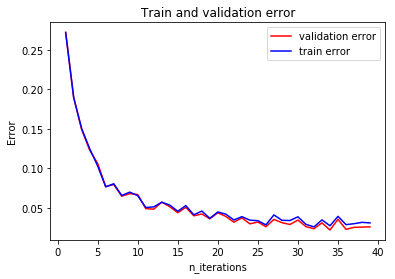

In [470]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [472]:
test_acc = predict(test_loader)
print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * test_acc))

Test Accuracy on the 10000 test images: 96.680000 %


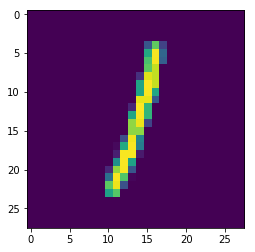

predicted label: 1
true label: 1


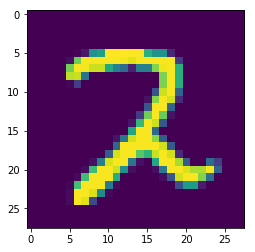

predicted label: 2
true label: 2


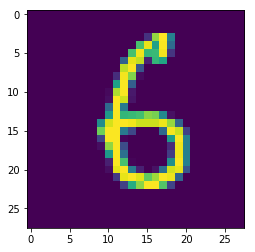

predicted label: 6
true label: 6


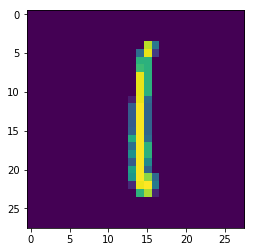

predicted label: 1
true label: 1


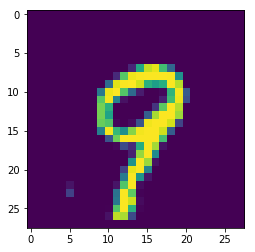

predicted label: 9
true label: 9


In [476]:
for i in range(5):
  image, label = next(iter(test_loader))  
  image = image[0]
  image = torch.squeeze(image)
  plt.imshow(image)
  plt.show()
  label = label[0]
  image = image.view(-1, sequence_length, input_size)
  image = image.cuda()
  label = label.cuda()
  output = model(image)
  predicted_label = torch.argmax(output)
  print('predicted label:',predicted_label.item())
  print('true label:',label.item())

#**Using LSTM Cells**

In [0]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 64
learning_rate = 0.002

In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate RNN
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [480]:
num_epochs = 10
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
        if (j%400==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
 

Train Epoch: 0 [25536/50000](51%)]	train_acc: 0.923500	val_acc: 0.924500
Train Epoch: 1 [1088/50000](2%)]	train_acc: 0.960260	val_acc: 0.960000
Train Epoch: 1 [26688/50000](53%)]	train_acc: 0.969020	val_acc: 0.969400
Train Epoch: 2 [2240/50000](4%)]	train_acc: 0.975580	val_acc: 0.973700
Train Epoch: 2 [27840/50000](56%)]	train_acc: 0.977080	val_acc: 0.975600
Train Epoch: 3 [3392/50000](7%)]	train_acc: 0.979900	val_acc: 0.973400
Train Epoch: 3 [28992/50000](58%)]	train_acc: 0.977920	val_acc: 0.973800
Train Epoch: 4 [4544/50000](9%)]	train_acc: 0.987760	val_acc: 0.983800
Train Epoch: 4 [30144/50000](60%)]	train_acc: 0.986380	val_acc: 0.982700
Train Epoch: 5 [5696/50000](11%)]	train_acc: 0.989160	val_acc: 0.984100
Train Epoch: 5 [31296/50000](63%)]	train_acc: 0.988780	val_acc: 0.984400
Train Epoch: 6 [6848/50000](14%)]	train_acc: 0.992160	val_acc: 0.986100
Train Epoch: 6 [32448/50000](65%)]	train_acc: 0.991760	val_acc: 0.985200
Train Epoch: 7 [8000/50000](16%)]	train_acc: 0.991780	val_acc

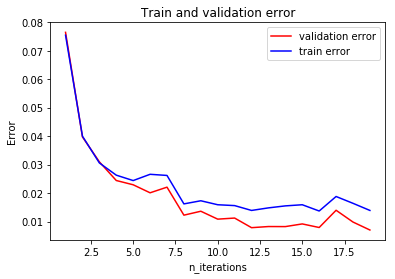

In [481]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [482]:
test_acc = predict(test_loader)
print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * test_acc))

Test Accuracy on the 10000 test images: 98.010000 %


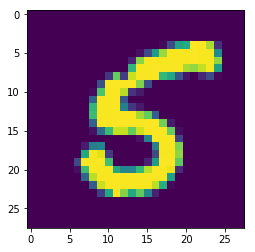

predicted label: 5
true label: 5


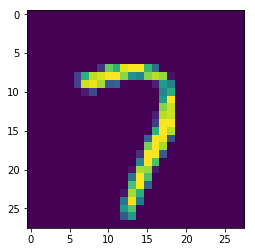

predicted label: 7
true label: 7


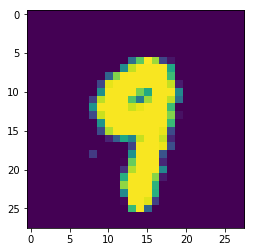

predicted label: 9
true label: 9


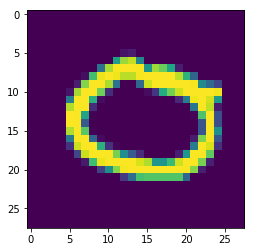

predicted label: 0
true label: 0


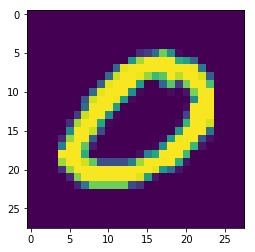

predicted label: 0
true label: 0


In [483]:
for i in range(5):
  image, label = next(iter(test_loader))  
  image = image[0]
  image = torch.squeeze(image)
  plt.imshow(image)
  plt.show()
  label = label[0]
  image = image.view(-1, sequence_length, input_size)
  image = image.cuda()
  label = label.cuda()
  output = model(image)
  predicted_label = torch.argmax(output)
  print('predicted label:',predicted_label.item())
  print('true label:',label.item())

In [0]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 64
learning_rate = 0.002

#**Using Bidirection LSTM Network**

In [0]:

class Bidirectional_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Bidirectional_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda()
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate RNN
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = Bidirectional_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [486]:
num_epochs = 15
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
        if (j%400==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
 

Train Epoch: 0 [25536/50000](51%)]	train_acc: 0.916420	val_acc: 0.920700
Train Epoch: 1 [1088/50000](2%)]	train_acc: 0.942280	val_acc: 0.943900
Train Epoch: 1 [26688/50000](53%)]	train_acc: 0.961280	val_acc: 0.960300
Train Epoch: 2 [2240/50000](4%)]	train_acc: 0.968040	val_acc: 0.968200
Train Epoch: 2 [27840/50000](56%)]	train_acc: 0.978800	val_acc: 0.976900
Train Epoch: 3 [3392/50000](7%)]	train_acc: 0.976380	val_acc: 0.974500
Train Epoch: 3 [28992/50000](58%)]	train_acc: 0.979380	val_acc: 0.975200
Train Epoch: 4 [4544/50000](9%)]	train_acc: 0.983360	val_acc: 0.979000
Train Epoch: 4 [30144/50000](60%)]	train_acc: 0.983920	val_acc: 0.979800
Train Epoch: 5 [5696/50000](11%)]	train_acc: 0.986360	val_acc: 0.982400
Train Epoch: 5 [31296/50000](63%)]	train_acc: 0.985060	val_acc: 0.979400
Train Epoch: 6 [6848/50000](14%)]	train_acc: 0.989400	val_acc: 0.985700
Train Epoch: 6 [32448/50000](65%)]	train_acc: 0.989060	val_acc: 0.983500
Train Epoch: 7 [8000/50000](16%)]	train_acc: 0.991520	val_acc

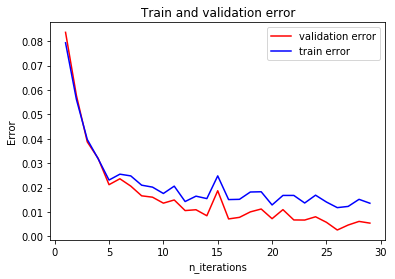

In [487]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [488]:
test_acc = predict(test_loader)
print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * test_acc))

Test Accuracy on the 10000 test images: 98.700000 %


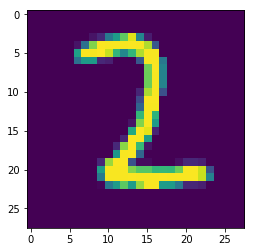

predicted label: 2
true label: 2


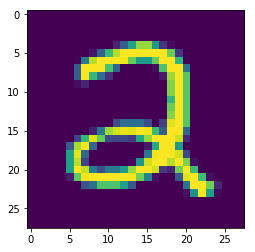

predicted label: 2
true label: 2


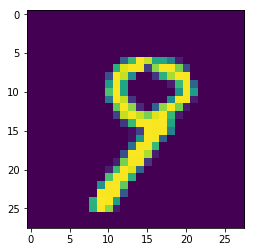

predicted label: 9
true label: 9


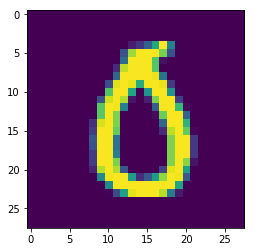

predicted label: 0
true label: 0


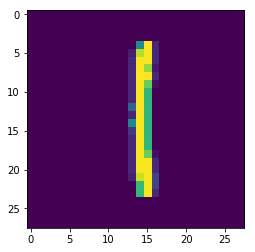

predicted label: 1
true label: 1


In [489]:
for i in range(5):
  image, label = next(iter(test_loader))  
  image = image[0]
  image = torch.squeeze(image)
  plt.imshow(image)
  plt.show()
  label = label[0]
  image = image.view(-1, sequence_length, input_size)
  image = image.cuda()
  label = label.cuda()
  output = model(image)
  predicted_label = torch.argmax(output)
  print('predicted label:',predicted_label.item())
  print('true label:',label.item())

***L-2 regularization for LSTM Model***

We simply add weight decay in the optimizer to do L-2 regularization

In [0]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 64
learning_rate = 0.002

In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate RNN
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [496]:
num_epochs = 10
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
        if (j%400==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
 

Train Epoch: 0 [25536/50000](51%)]	train_acc: 0.915240	val_acc: 0.917300
Train Epoch: 1 [1088/50000](2%)]	train_acc: 0.957040	val_acc: 0.956000
Train Epoch: 1 [26688/50000](53%)]	train_acc: 0.969280	val_acc: 0.967700
Train Epoch: 2 [2240/50000](4%)]	train_acc: 0.972580	val_acc: 0.970900
Train Epoch: 2 [27840/50000](56%)]	train_acc: 0.963260	val_acc: 0.961300
Train Epoch: 3 [3392/50000](7%)]	train_acc: 0.973920	val_acc: 0.971800
Train Epoch: 3 [28992/50000](58%)]	train_acc: 0.982720	val_acc: 0.980900
Train Epoch: 4 [4544/50000](9%)]	train_acc: 0.963360	val_acc: 0.960600
Train Epoch: 4 [30144/50000](60%)]	train_acc: 0.984560	val_acc: 0.979100
Train Epoch: 5 [5696/50000](11%)]	train_acc: 0.984940	val_acc: 0.981800
Train Epoch: 5 [31296/50000](63%)]	train_acc: 0.986640	val_acc: 0.984100
Train Epoch: 6 [6848/50000](14%)]	train_acc: 0.984360	val_acc: 0.979500
Train Epoch: 6 [32448/50000](65%)]	train_acc: 0.988820	val_acc: 0.983100
Train Epoch: 7 [8000/50000](16%)]	train_acc: 0.989460	val_acc

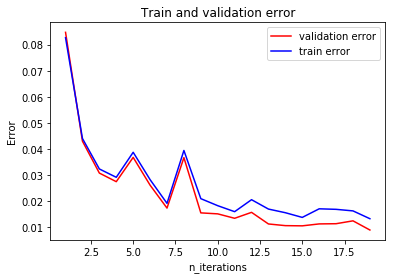

In [502]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

Convergence is faster after adding l2 regularization also there is improvement in the test accuracy

In [498]:
test_acc = predict(test_loader)
print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * test_acc))

Test Accuracy on the 10000 test images: 98.500000 %


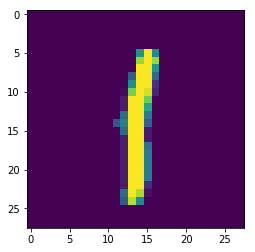

predicted label: 1
true label: 1


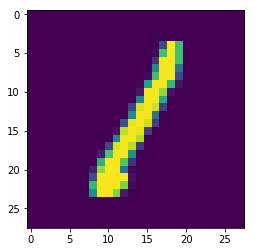

predicted label: 1
true label: 1


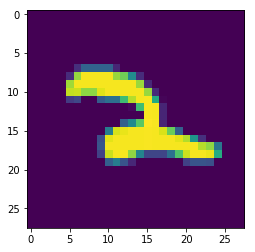

predicted label: 2
true label: 2


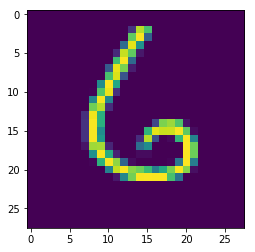

predicted label: 6
true label: 6


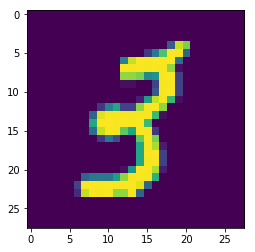

predicted label: 3
true label: 3


In [499]:
for i in range(5):
  image, label = next(iter(test_loader))  
  image = image[0]
  image = torch.squeeze(image)
  plt.imshow(image)
  plt.show()
  label = label[0]
  image = image.view(-1, sequence_length, input_size)
  image = image.cuda()
  label = label.cuda()
  output = model(image)
  predicted_label = torch.argmax(output)
  print('predicted label:',predicted_label.item())
  print('true label:',label.item())

#**Remembering the number at a particular index in a given sequence**

In [0]:
position = 3                           #position to be remembered

In [0]:
def generate_random_sample():
    random_length = np.random.randint(3,11)
    return np.random.randint(0,10,random_length)

In [0]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [0]:
def train_sample():
  
  grs = generate_random_sample()
  input1 = one_hot(grs,10).tolist()
  
  return (input1,grs[position-1])

**Creating Dataset**


In [0]:
data_size = 20000
data = []

for i in range(data_size):
  zero_pad = torch.zeros(10,10)
  
  ts =  train_sample()
  sample = ts[0]
  label = ts[1]
  zero_pad[:len(sample),:] = torch.FloatTensor(sample)
  data.append((zero_pad,label))
  

In [0]:
train_data,test_data, val_data = torch.utils.data.random_split(data, lengths= [16000,2000,2000])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

**hidden size = 2**

In [0]:
sequence_length = 10
input_size = 10
hidden_size = 2
num_layers = 2
num_classes = 10
#batch_size = 64
learning_rate = 0.009


In [0]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        out, _ = self.RNN(x,c0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def predict(loader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)
            images = images
            labels = labels
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total
         

In [645]:
num_epochs = 50
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.101938	val_acc: 0.105000
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.104875	val_acc: 0.105500
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.099250	val_acc: 0.092000
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.099062	val_acc: 0.095500
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.107063	val_acc: 0.104500
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.107313	val_acc: 0.090000
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.106938	val_acc: 0.089500
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.101250	val_acc: 0.098000
Train Epoch: 7 [3136/16000](20%)]	train_acc: 0.106563	val_acc: 0.105500
Train Epoch: 7 [15936/16000](100%)]	train_acc: 0.107750	val_acc: 0.093000
Train Epoch: 8 [12736/16000](80%)]	train_acc: 0.117750	val_acc: 0.115500
Train Epoch: 9 [9536/16000](60%)]	train_acc: 0.201125	val_acc: 0.187500
Train Epoch: 10 [6336/16000](40%)]	train_acc: 0.200687	val_acc: 0.200500
Train Epoch: 11 [3136/16000](20%)]	train_acc: 0.197937	v

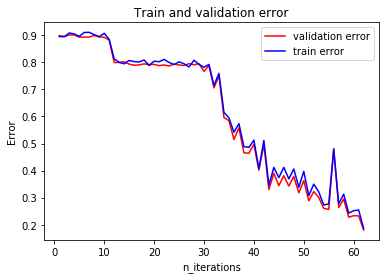

In [647]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [648]:
print('test accuracy:',predict(test_loader))

test accuracy: 0.823


**Hidden Size = 3**

In [0]:
sequence_length = 10
input_size = 10
hidden_size = 3
num_layers = 2
num_classes = 10
#batch_size = 64
learning_rate = 0.001


In [0]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        out, _ = self.RNN(x,c0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [817]:
num_epochs = 50
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.099750	val_acc: 0.113500
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.103188	val_acc: 0.095500
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.103438	val_acc: 0.107000
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.101938	val_acc: 0.101500
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.105500	val_acc: 0.093500
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.102625	val_acc: 0.104500
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.102688	val_acc: 0.105500
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.105313	val_acc: 0.092000
Train Epoch: 7 [3136/16000](20%)]	train_acc: 0.102750	val_acc: 0.086000
Train Epoch: 7 [15936/16000](100%)]	train_acc: 0.102250	val_acc: 0.102000
Train Epoch: 8 [12736/16000](80%)]	train_acc: 0.104188	val_acc: 0.105500
Train Epoch: 9 [9536/16000](60%)]	train_acc: 0.104188	val_acc: 0.108500
Train Epoch: 10 [6336/16000](40%)]	train_acc: 0.103750	val_acc: 0.110500
Train Epoch: 11 [3136/16000](20%)]	train_acc: 0.105563	v

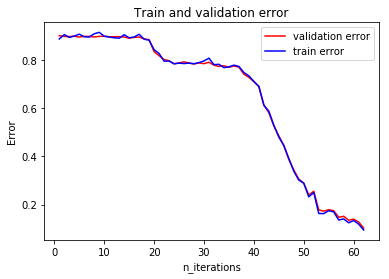

In [818]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [820]:
print('test accuracy:',predict(test_loader))

test accuracy: 0.8825


**Hidden Size = 5**

In [0]:
sequence_length = 10
input_size = 10
hidden_size = 5
num_layers = 1
num_classes = 10
#batch_size = 64
learning_rate = 0.0008


In [0]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        out, _ = self.RNN(x,c0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [688]:
num_epochs = 100
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        j = j + 1
        
        images = images.reshape(-1, sequence_length, input_size)
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.108625	val_acc: 0.096500
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.109625	val_acc: 0.097000
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.110437	val_acc: 0.098000
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.108063	val_acc: 0.095500
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.167875	val_acc: 0.166000
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.172687	val_acc: 0.162000
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.180750	val_acc: 0.177000
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.186875	val_acc: 0.184500
Train Epoch: 7 [3136/16000](20%)]	train_acc: 0.223375	val_acc: 0.207000
Train Epoch: 7 [15936/16000](100%)]	train_acc: 0.245938	val_acc: 0.237500
Train Epoch: 8 [12736/16000](80%)]	train_acc: 0.271250	val_acc: 0.276000
Train Epoch: 9 [9536/16000](60%)]	train_acc: 0.317625	val_acc: 0.317500
Train Epoch: 10 [6336/16000](40%)]	train_acc: 0.357563	val_acc: 0.357500
Train Epoch: 11 [3136/16000](20%)]	train_acc: 0.388188	v

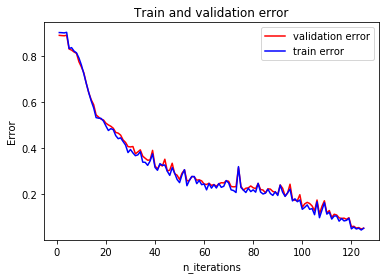

In [689]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [693]:
print('test accuracy:',predict(test_loader))

test accuracy: 0.9395


With increasing no of hidden size network was able to learn better

In [707]:
for i in range(5):
  x = iter(test_loader).next()
  inputseq = x[0][0]
  targetno = x[1][0]
  print(inputseq)
  inputseq = inputseq.reshape(-1, sequence_length, input_size)
  outputs = model(inputseq)
  outputs = outputs.data
  outputs = torch.argmax(torch.squeeze(outputs))
  print('Expected Learned no:',int(targetno))
  print('Learnt no:',int(outputs))

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Expected Learned no: 4
Learnt no: 4
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 

**ADD two binary strings using RNN**

**L = 3**

In [0]:
L = 3
max_str = '1'*L
max_int = int(max_str,2)

In [0]:
def gen_rand_bin(L):
    x = np.random.randint(0,max_int+1)
    return list(map(int,list(format(x, '0'+str(L+1)+'b')))),x

In [0]:
def gen_training_sample(L):
  bin1 = gen_rand_bin(L)
  bin2 = gen_rand_bin(L)
  input1 = bin1[0]
  input2 = bin2[0]
  sum_bin = list(map(int,list(format(bin1[1]+bin2[1], '0'+str(L+1)+'b'))))
  return (torch.Tensor(input1),torch.Tensor(input2),torch.Tensor(sum_bin))

In [0]:
data_size = 20000
data = []

for i in range(data_size):
  data.append(gen_training_sample(L))
  

In [0]:
train_data,test_data, val_data = torch.utils.data.random_split(data, lengths= [16000,2000,2000])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

**MSE LOSS**

In [0]:
sequence_length = L+1
input_size = 2
hidden_size = 5
num_layers = 1
num_classes = 1
#batch_size = 64
learning_rate = 0.001


In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out1 = out.contiguous().view(-1,hidden_size)
        # Decode the hidden state of the last time step
    
        out = self.fc(out1)
        out = F.sigmoid(out)
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def bit_accuracy(loader):
    bit_err = 0
    total= 0
    with torch.no_grad():
      for data in loader:
          input1 = data[0]
          input2 = data[1]
          labels = data[2]
          input1 = torch.flip(input1,[1])
          input2 = torch.flip(input2,[1])
          labels = torch.flip(labels,[1])
          labels = labels.numpy()
          input1 = input1.reshape(-1, sequence_length, 1)
          input2 = input2.reshape(-1, sequence_length, 1)
          final_input = torch.cat((input1,input2),2)
          out = model(final_input)
          out = out.view(-1,L+1)
          out = out.data
          out = torch.squeeze(out).numpy()
          out[out>=0.5] = 1
          out[out<0.5] = 0
          total += labels.shape[0]
          bit_err = bit_err + sum(sum(abs(out-labels)))
    return 1- bit_err/(total*(L+1))
     
          

In [747]:

num_epochs = 13
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (input1,input2, labels) in enumerate(train_loader):
        j = j + 1
        input1 = torch.flip(input1,[1])
        input2 = torch.flip(input2,[1])
        labels = torch.flip(labels,[1])
        input1 = input1.reshape(-1, sequence_length, 1)
        input2 = input2.reshape(-1, sequence_length, 1)
        final_input = torch.cat((input1,input2),2)
        # Forward pass
        outputs = model(final_input)
        outputs = outputs.view(-1,L+1)
       
        #labels = torch.Tensor(labels).type(torch.LongTensor)
        loss = criterion(outputs, labels)
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        if (j%200==0):
          val_acc = bit_accuracy(val_loader)
          train_acc = bit_accuracy(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.529750	val_acc: 0.528125
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.612203	val_acc: 0.610125
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.779750	val_acc: 0.776500
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.861922	val_acc: 0.861875
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.889703	val_acc: 0.888500
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.878062	val_acc: 0.875125
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.874344	val_acc: 0.871750
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.881766	val_acc: 0.879125
Train Epoch: 7 [3136/16000](20%)]	train_acc: 0.915500	val_acc: 0.915250
Train Epoch: 7 [15936/16000](100%)]	train_acc: 0.915500	val_acc: 0.915250
Train Epoch: 8 [12736/16000](80%)]	train_acc: 0.919031	val_acc: 0.920250
Train Epoch: 9 [9536/16000](60%)]	train_acc: 0.927359	val_acc: 0.929125
Train Epoch: 10 [6336/16000](40%)]	train_acc: 0.974187	val_acc: 0.972500
Train Epoch: 11 [3136/16000](20%)]	train_acc: 0.988469	v

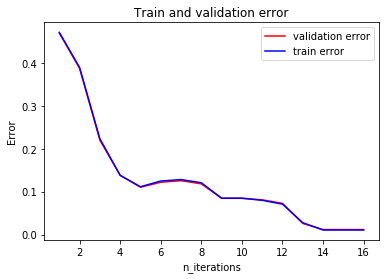

In [748]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [749]:
print('bit accuracy on test samples:',bit_accuracy(test_loader)*100,'%')

bit accuracy on test samples: 99.02499999999999 %


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


**Cross Entropy Loss**

Pytorch doesn't have sigmoid cross entropy loss like tendorflow. It comes as Multilabel soft margin loss

In [0]:
sequence_length = L+1
input_size = 2
hidden_size = 5
num_layers = 1
num_classes = 1
#batch_size = 64
learning_rate = 0.001


In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out1 = out.contiguous().view(-1,hidden_size)
        # Decode the hidden state of the last time step
    
        out = self.fc(out1)
        #out = F.sigmoid(out)
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [753]:

num_epochs = 10
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (input1,input2, labels) in enumerate(train_loader):
        j = j + 1
        input1 = torch.flip(input1,[1])
        input2 = torch.flip(input2,[1])
        labels = torch.flip(labels,[1])
        input1 = input1.reshape(-1, sequence_length, 1)
        input2 = input2.reshape(-1, sequence_length, 1)
        final_input = torch.cat((input1,input2),2)
        # Forward pass
        outputs = model(final_input)
        outputs = outputs.view(-1,L+1)
       
        #labels = torch.Tensor(labels).type(torch.LongTensor)
        loss = criterion(outputs, labels)
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = bit_accuracy(val_loader)
          train_acc = bit_accuracy(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.515203	val_acc: 0.520875
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.527594	val_acc: 0.532875
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.559594	val_acc: 0.563625
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.677875	val_acc: 0.677875
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.713078	val_acc: 0.714500
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.749797	val_acc: 0.752625
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.822281	val_acc: 0.823125
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.880234	val_acc: 0.883250
Train Epoch: 7 [3136/16000](20%)]	train_acc: 0.916203	val_acc: 0.919250
Train Epoch: 7 [15936/16000](100%)]	train_acc: 0.930031	val_acc: 0.933250
Train Epoch: 8 [12736/16000](80%)]	train_acc: 0.964766	val_acc: 0.964375
Train Epoch: 9 [9536/16000](60%)]	train_acc: 0.979953	val_acc: 0.978750


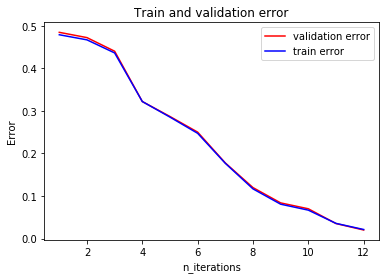

In [754]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [755]:
print('bit accuracy on test samples:',bit_accuracy(test_loader)*100,'%')

bit accuracy on test samples: 98.6125 %


**L = 5**

In [0]:
L = 5
max_str = '1'*L
max_int = int(max_str,2)

In [0]:
data_size = 20000
data = []

for i in range(data_size):
  data.append(gen_training_sample(L))
  

In [0]:
train_data,test_data, val_data = torch.utils.data.random_split(data, lengths= [16000,2000,2000])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

In [0]:
sequence_length = L+1
input_size = 2
hidden_size = 5
num_layers = 1
num_classes = 1
#batch_size = 64
learning_rate = 0.001


In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out1 = out.contiguous().view(-1,hidden_size)
        # Decode the hidden state of the last time step
    
        out = self.fc(out1)
        #out = F.sigmoid(out)
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [789]:

num_epochs = 10
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (input1,input2, labels) in enumerate(train_loader):
        j = j + 1
        input1 = torch.flip(input1,[1])
        input2 = torch.flip(input2,[1])
        labels = torch.flip(labels,[1])
        input1 = input1.reshape(-1, sequence_length, 1)
        input2 = input2.reshape(-1, sequence_length, 1)
        final_input = torch.cat((input1,input2),2)
        # Forward pass
        outputs = model(final_input)
        outputs = outputs.view(-1,L+1)
       
        #labels = torch.Tensor(labels).type(torch.LongTensor)
        loss = criterion(outputs, labels)
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = bit_accuracy(val_loader)
          train_acc = bit_accuracy(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.567792	val_acc: 0.560167
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.616354	val_acc: 0.608917
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.826302	val_acc: 0.822083
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.930583	val_acc: 0.929833
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.937010	val_acc: 0.935917
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.971990	val_acc: 0.973583
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.997990	val_acc: 0.998083
Train Epoch: 6 [6336/16000](40%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 7 [3136/16000](20%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 7 [15936/16000](100%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 8 [12736/16000](80%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 9 [9536/16000](60%)]	train_acc: 1.000000	val_acc: 1.000000


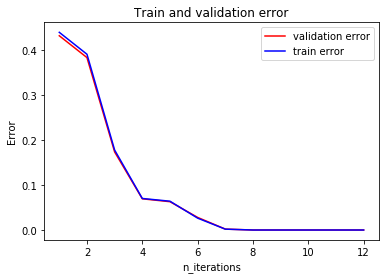

In [790]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [791]:
print('bit accuracy on test samples:',bit_accuracy(test_loader)*100,'%')

bit accuracy on test samples: 100.0 %


**L=10**

In [0]:
L = 10
max_str = '1'*L
max_int = int(max_str,2)

In [0]:
data_size = 20000
data = []

for i in range(data_size):
  data.append(gen_training_sample(L))
  

In [0]:
train_data,test_data, val_data = torch.utils.data.random_split(data, lengths= [16000,2000,2000])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

In [0]:
sequence_length = L+1
input_size = 2
hidden_size = 8
num_layers = 1
num_classes = 1
#batch_size = 64
learning_rate = 0.001


In [0]:

class model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(model_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate RNN
        
        out, _ = self.LSTM1(x, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out1 = out.contiguous().view(-1,hidden_size)
        # Decode the hidden state of the last time step
    
        out = self.fc(out1)
        #out = F.sigmoid(out)
        return out

model = model_LSTM(input_size, hidden_size, num_layers, num_classes)
model = model

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [805]:

num_epochs = 10
total_step = len(train_loader)
val_error = []
train_error = []
j = 0
for epoch in range(num_epochs):
    for i, (input1,input2, labels) in enumerate(train_loader):
        j = j + 1
        input1 = torch.flip(input1,[1])
        input2 = torch.flip(input2,[1])
        labels = torch.flip(labels,[1])
        input1 = input1.reshape(-1, sequence_length, 1)
        input2 = input2.reshape(-1, sequence_length, 1)
        final_input = torch.cat((input1,input2),2)
        # Forward pass
        outputs = model(final_input)
        outputs = outputs.view(-1,L+1)
       
        #labels = torch.Tensor(labels).type(torch.LongTensor)
        loss = criterion(outputs, labels)
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (j%200==0):
          val_acc = bit_accuracy(val_loader)
          train_acc = bit_accuracy(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),100. * i / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

    
   

Train Epoch: 0 [12736/16000](80%)]	train_acc: 0.516415	val_acc: 0.511000
Train Epoch: 1 [9536/16000](60%)]	train_acc: 0.500909	val_acc: 0.494864
Train Epoch: 2 [6336/16000](40%)]	train_acc: 0.543489	val_acc: 0.541591
Train Epoch: 3 [3136/16000](20%)]	train_acc: 0.643557	val_acc: 0.644636
Train Epoch: 3 [15936/16000](100%)]	train_acc: 0.619091	val_acc: 0.619636
Train Epoch: 4 [12736/16000](80%)]	train_acc: 0.688773	val_acc: 0.687136
Train Epoch: 5 [9536/16000](60%)]	train_acc: 0.808966	val_acc: 0.810409
Train Epoch: 6 [6336/16000](40%)]	train_acc: 0.974693	val_acc: 0.975364
Train Epoch: 7 [3136/16000](20%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 7 [15936/16000](100%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 8 [12736/16000](80%)]	train_acc: 1.000000	val_acc: 1.000000
Train Epoch: 9 [9536/16000](60%)]	train_acc: 1.000000	val_acc: 1.000000


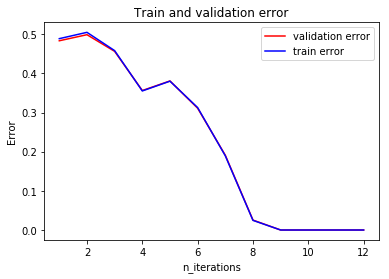

In [806]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

In [807]:
print('bit accuracy on test samples:',bit_accuracy(test_loader)*100,'%')

bit accuracy on test samples: 100.0 %


With all L = 3,5 ,10 network was able to completely add two binary sequence with almost 100 % accuracy.